In this notebook we cover the basics of TEM image formation: taking a 3D protein structure and turning it into a noisy image in the TEM.

First we download a pdb turn it into a density map with eman.

Today we are using Human olfactory receptor OR51E2 (https://www.rcsb.org/structure/8F76), pdb's molecule of the month from June 2023 (https://pdb101.rcsb.org/motm/282)and by happenstance a GPCR! ☺

In [1]:

import urllib.request      
import os

# Download the pdb
pdb = '8F76'
if not os.path.exists('{0}.pdb'.format(pdb)):
    urllib.request.urlretrieve('https://files.rcsb.org/download/{0}.pdb'.format(pdb), '{0}.pdb'.format(pdb))

# The next bit only works on a system with eman2 installed so is commented out
apix = 1.5
box = [128]*3

# os.system('conda activate eman2')
# os.system('e2pdb2mrc.py --apix {1} --box {2} --res {3} --center {0}.pdb {0}.mrc'.format(pdb,apix,box[0],2*apix))

It is best to view the structure in Chimera (either the mrc or the pdb file) as this is the best option for 3D viewer.

We can quickly look at the projection of the density map in Python however:

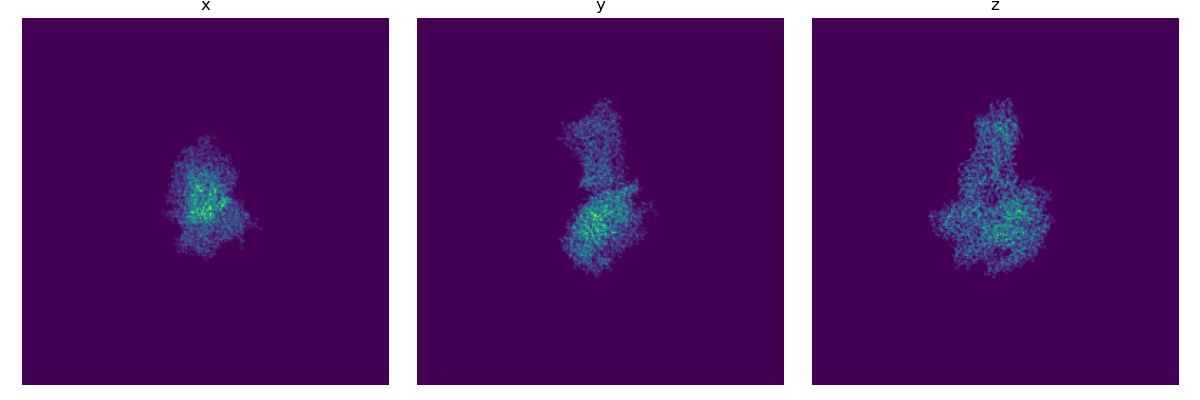

In [93]:
import mrcfile as mrc
import matplotlib.pyplot as plt
import numpy as np

m = mrc.open('{0}.mrc'.format(pdb),'r')
volume = np.asarray(m.data)
psize = m.voxel_size['x']
fig,ax = plt.subplots(ncols=3,figsize=(12,4))
for i in range(3):
    ax[i].imshow(np.sum(volume,axis=i))

for a,title in zip(ax,['x','y','z']): 
    a.set_axis_off()
    a.set_title(title)
fig.tight_layout()


Now we introduce the electron, the electron wave acquires a phase (ie the wave "slows down") as it passes through the molecule. Let's look at the probability density of the wave after it interacts with the protein:

Text(0.5, 1.0, 'Observed electron wavefunction')

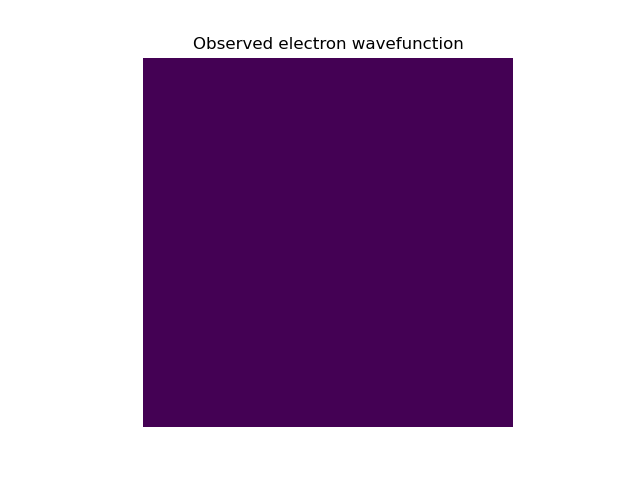

In [103]:
from functions import *
eV = 3e5 #300 kV electron
lam = 1/wavev(eV) #This function converts between electron energy (in eV) and wavelength in (Angstrom)

# Project protein
proj = np.mean(volume,axis=i)

wavefunction = 1*np.exp(1j*proj)

fig,ax =plt.subplots()
ax.imshow(np.abs(wavefunction)**2)
ax.set_axis_off()
ax.set_title('Observed electron wavefunction')


It turns out we actually need to propagate the wave a little further down the TEM and then we can see what a TEM image would look like

interactive(children=(FloatSlider(value=0.0, description='$\\Delta$f ($\\mu$m):', max=5.0, min=-5.0, step=0.01…

<function __main__.plot_propagator(dz, cstoggle)>

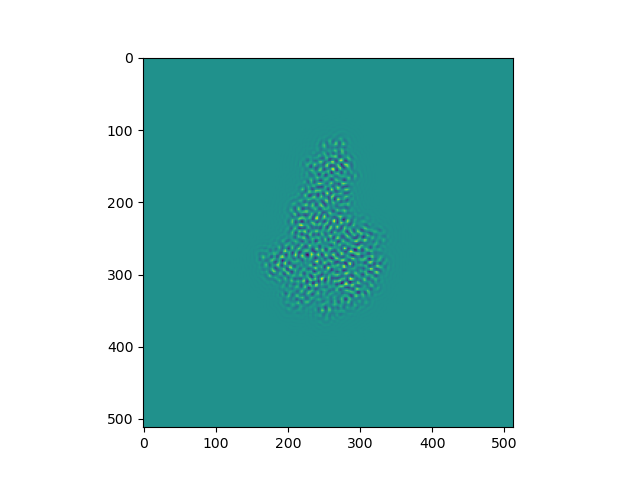

In [104]:
import ipywidgets as widgets
# for creating a responsive plot
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib widget
from functions import make_contrast_transfer_function as ctf

fig,ax = plt.subplots()

im = ax.imshow(np.zeros((512,512)),vmin=0.8,vmax=1.2)

pixels = volume.shape[0]
size = psize*pixels

def plot_propagator(dz,cstoggle):
    """Function to plot the propagator"""
    gaussian = Gaussian(1,[pixels,pixels],[size,size])
    if cstoggle:
        propagator = ctf([pixels,pixels],[size,size],eV,df=dz*1e4,aberrations=cs(2.7))
    else:
        propagator = ctf([pixels,pixels],[size,size],eV,df=dz*1e4,aberrations=[])
    img = np.abs(np.fft.ifft2(np.fft.fft2(wavefunction)*propagator*np.fft.fft2(gaussian)))**2
#     im.set_data(img)
#     img  = np.angle(propagator)
    im.set_data(img)
    im.set_clim(vmin=img.min(),vmax=img.max())
    

interact(plot_propagator, dz = widgets.FloatSlider(value=0.0,
                                               min=-5,
                                               max=5,
                                               step=0.01,description='$\\Delta$f ($\\mu$m):', readout_format='.2f'),
         cstoggle = widgets.Checkbox(value=True,description='Cs On'))

Of course this is not what images of proteins actually look like inside the TEM, we need to add counting noise (from a finite dose) to get a more realistic picture

256.0 1.0


interactive(children=(FloatSlider(value=0.0, description='$\\Delta$f ($\\mu$m):', max=5.0, min=-5.0, step=0.01…

<function __main__.plot_propagator(dz, dose)>

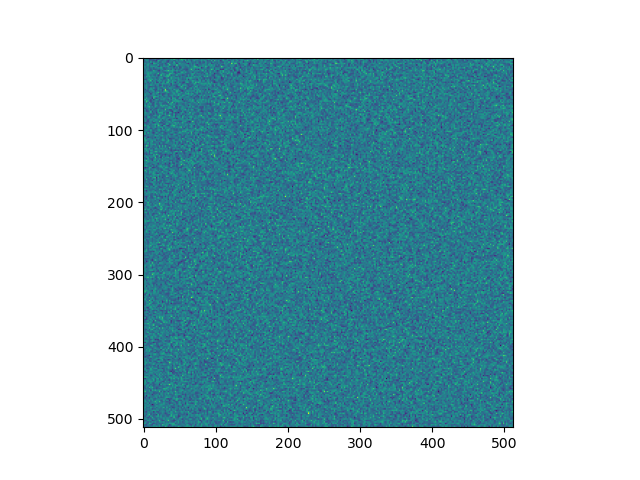

In [105]:
fig,ax = plt.subplots()

im = ax.imshow(np.zeros((512,512)),vmin=0.8,vmax=1.2)

pixels = volume.shape[0]
size = psize*pixels
print(size,psize)

def add_noise(arrayin, Total_counts):
    """
    Add Poisson counting noise to simulated data.

    Parameters
    ----------
    arrayin : array_like
        Array giving the fraction of Total_counts that is expected at each pixel
        in the array.
    Total_counts : float
        Total number of electron counts expected over the array.
    """
    return np.random.poisson(arrayin * Total_counts)

def plot_propagator(dz,dose):
    """Function to plot the propagator"""
    gaussian = Gaussian(1,[pixels,pixels],[size,size])
    propagator = ctf([pixels,pixels],[size,size],eV,df=dz*1e4,aberrations=cs(2.7))
    img = np.abs(np.fft.ifft2(np.fft.fft2(wavefunction)*propagator*np.fft.fft2(gaussian)))**2
    counts = dose*size*size
    img = img/np.sum(img)
    img = add_noise(img,counts )
    im.set_data(img)
    im.set_clim(vmin=img.min(),vmax=img.max())
    

interact(plot_propagator, dz = widgets.FloatSlider(value=0.0,
                                               min=-5,
                                               max=5,
                                               step=0.01,description='$\\Delta$f ($\\mu$m):', readout_format='.2f')
         , dose = widgets.FloatLogSlider(value=40,
                                         base=10,
                                               min=1,
                                               max=5,
                                               step=0.01,description='e/Å$^2$:', readout_format='.2e'))

So far we've only been dealing with a single projection view of the protein and it would be nice to get a view down other axes. We need to do a little homework in terms of how we can represent different orientations mathematically. For this we use Euler angles. Wikipedia has a nice explainer: https://en.wikipedia.org/wiki/Euler_angles. In the cell below you can observe how changing different Euler angles moves a set of arrows in 3D space:

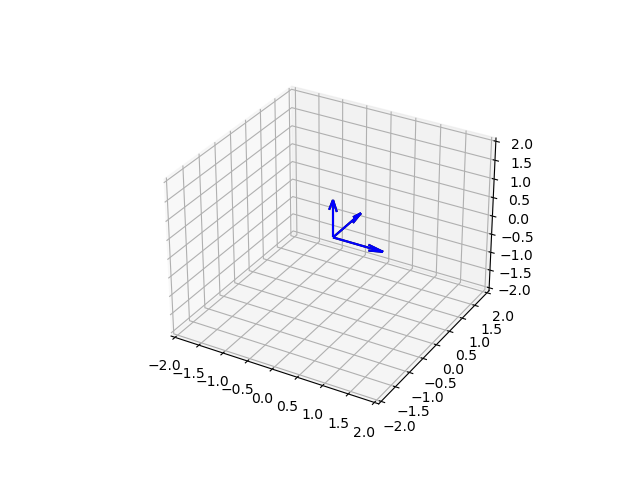

FloatSlider(value=0.0, description='rot:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='tilt:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='psi:', max=360.0, step=1.0)

In [106]:
# for creating a responsive plot
%matplotlib widget
import ipywidgets as widgets

# make plots
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
I = np.eye(3)
ax.quiver(*np.zeros((3,3)),*I,color='k')
quiv = ax.quiver(*np.zeros((3,3)),*I,color='b')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])
plt.show()

from scipy.spatial.transform import Rotation

def update_position(change):
    """Function to update plot when slider changes"""
    # Get the new X and Y values from the sliders
    ax.clear()
    I = np.eye(3)
    ax.quiver(*np.zeros((3,3)),*I,color='k')
    rot,tilt,psi = [slider_rot.value,slider_tilt.value,slider_psi.value]
    R = Rotation.from_euler('zyz',[rot,tilt,psi],degrees=True)
#     O = np.zeros((3,3))
#     print([[(oo,xx) for oo,xx in zip(o,x)] for o,x in zip(O,R.as_matrix())])
#     quiv.set_segments([[(oo,xx) for oo,xx in zip(o,x)] for o,x in zip(O,R.as_matrix().T)])
    quiv = ax.quiver(*np.zeros((3,3)),*R.as_matrix().T,color='b')
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])
#     plt.show()
#     quiv.draw()
    

# Create the rot position slider
slider_rot = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='rot:')

# Create the tilt position slider
slider_tilt = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='tilt:')

# Creat the tilt position
slider_psi = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='psi:')

# Connect sliders to update function
slider_rot.observe(update_position, names='value')
slider_tilt.observe(update_position, names='value')
slider_psi.observe(update_position, names='value')

#Display sliders
display(slider_rot)
display(slider_tilt)
display(slider_psi)

Now let's have a look at our 3D volume down a few different axes.

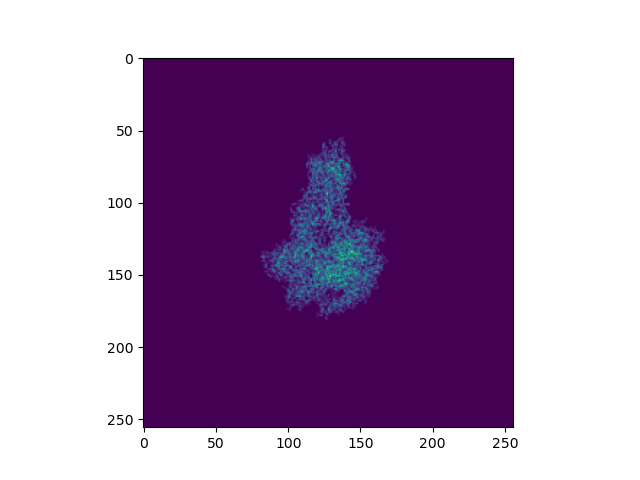

FloatSlider(value=0.0, description='rot:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='tilt:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='psi:', max=360.0, step=1.0)

In [107]:
from scipy.ndimage import affine_transform

# for creating a responsive plot
%matplotlib widget
import ipywidgets as widgets

# make plots
fig,ax = plt.subplots()
im = ax.imshow(np.sum(volume,axis=2))
plt.show()

from scipy.spatial.transform import Rotation

def update_position(change):
    """Function to update plot when slider changes"""
    # Get the new X and Y values from the sliders
    
    rot,tilt,psi = [slider_rot.value,slider_tilt.value,slider_psi.value]
    R = Rotation.from_euler('zyz',[rot,tilt,psi],degrees=True)
    offset = np.asarray(volume.shape)/2
    offset = offset-offset.dot(R.as_matrix())
    # Transform volume
    V = affine_transform(volume, R.inv().as_matrix(),order=1,offset = offset)
    im.set_data(np.sum(V,axis=2))
    

# Create the rot position slider
slider_rot = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='rot:')

# Create the tilt position slider
slider_tilt = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='tilt:')

# Creat the tilt position
slider_psi = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='psi:')

# Connect sliders to update function
slider_rot.observe(update_position, names='value')
slider_tilt.observe(update_position, names='value')
slider_psi.observe(update_position, names='value')

#Display sliders
display(slider_rot)
display(slider_tilt)
display(slider_psi)

Unless your computer is exceptionally fast the above cell would have been a painful experience for you. Thankfully we can speed things up significantly with (once again) a bit of Fourier space magic. First let's introduce the Fourier projection theorem. This is difficult to demonstrate in 3D, so we'll start in 2D.

If we remove all but a single "line" of points in Fourier space this has the effect of "projecting" our 2D object into a single dimension. The implication is that the line of Fourier coefficients describes the "average" image in a single direction - the "projection image".

interactive(children=(FloatSlider(value=0.0, description='Angle:', max=180.0, min=-180.0, step=1.0), FloatSlid…

<function __main__.plot(angle, length)>

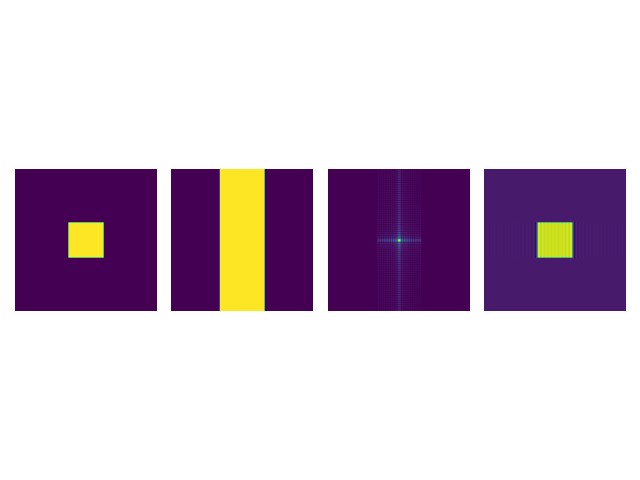

In [108]:
from scipy.datasets import ascent


def plane_filter(shape,angle,width):
    y,x = shape
    yy,xx = [np.fft.fftfreq(i,1/i) for i in [y,x]]
    rad = np.deg2rad(angle)
    coords = np.stack(np.broadcast_arrays(yy[:,None],xx[None,:]),axis=2)
    length = np.dot(coords,[np.sin(rad),np.cos(rad)])
    filt = (np.abs(length)<=width).astype(int)
    return filt
pix = 256
r = pix // 4
square = np.zeros((pix,pix))
square[:r,:r]=1
img = np.roll(square,[(pix-r)//2]*2,axis=(0,1))
fig,ax = plt.subplots(ncols=4)
ax[0].imshow(img)
filt = plane_filter(img.shape,30,15)
im1 =  ax[1].imshow(np.fft.fftshift(filt))
im2 = ax[2].imshow(np.real(np.fft.fftshift(np.fft.fft2(img)*filt)))
im3 = ax[3].imshow(np.real(np.fft.ifft2(np.fft.fft2(img)*filt)))
for a in ax: a.set_axis_off()
fig.tight_layout()
    
# plane_filter(img.shape,30,10)

def plot(angle,length):
    """Function to plot the propagator"""
    filt = plane_filter(img.shape,angle,length)
    filt_img = np.fft.fft2(img)*filt
    logabs= np.fft.fftshift(np.sqrt(np.abs(np.fft.fft2(img)))*filt)
    im2.set_data(logabs)
    im2.set_clim(vmin=logabs.min(),vmax=logabs.max())
    filt_img = np.real(np.fft.ifft2(filt_img))
    
    im1.set_data(np.fft.fftshift(filt))
    im3.set_data(filt_img)
    im3.set_clim(vmin=filt_img.min(),vmax=filt_img.max())
    

interact(plot, angle = widgets.FloatSlider(value=0.0,
                                               min=-180,
                                               max=180,
                                               step=1,description='Angle:', readout_format='.2f')
         , length = widgets.FloatSlider(value=40,
                                               min=0.5,
                                               max=img.shape[0],
                                               step=0.1,description='width:', readout_format='.2f'))

If we take this concept to 3D space, a plane of points in the 3D Fourier transform corresponds to the structure projected into a single 2D plane. We can project our structure from 3D down into 2D by just taking a plane of Fourier coefficients, putting them into a 2D plane and inverse Fourier transforming. While much more concepturally complicated this is far superior to than rotating the full structure in 3D and then projecting from a computational perspective!

FloatSlider(value=0.0, description='rot:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='tilt:', max=360.0, step=1.0)

FloatSlider(value=0.0, description='psi:', max=360.0, step=1.0)

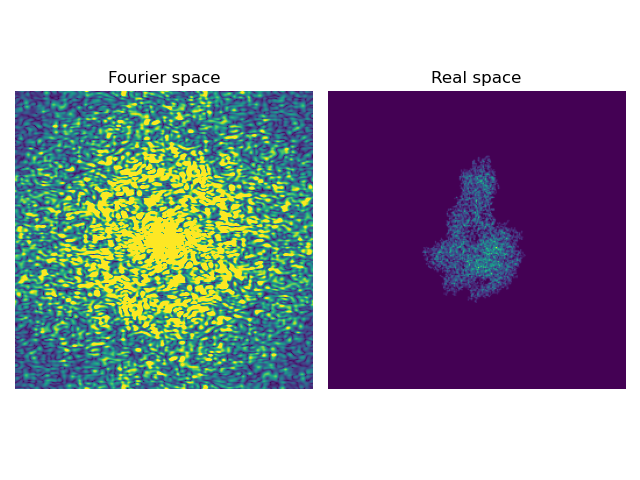

In [109]:
from scipy.ndimage import affine_transform
from scipy.interpolate import RegularGridInterpolator

grid = [np.arange(x) -x//2 for x in volume.shape]


# Fourier transform volume
volfft = np.fft.ifftshift(np.fft.fftn(np.fft.fftshift(volume)))

# We will need to "interpolate" the grid - estimate values in between the pixels and this
# function prepares for that
vol = RegularGridInterpolator(grid,volfft,method="linear",bounds_error=False,fill_value=0)

# make plots
fig,axes = plt.subplots(ncols=2)
im = axes[0].imshow(np.abs(volfft[:,:,volume.shape[2]//2]),vmax=np.amax(np.abs(volfft))*1e-2)
im2 = axes[1].imshow(np.sum(volume,axis=2))
for a,title in zip(axes,['Fourier space','Real space']): 
                   a.set_axis_off()
                   a.set_title(title)
fig.tight_layout()

from scipy.spatial.transform import Rotation

def project_volume(vol,rot,tilt,psi,returnfft=False):
    R = Rotation.from_euler('zyz',[rot,tilt,psi],degrees=True).as_matrix()
    
    # Generate coordinates of plane normal to projection direction
    x = R[0].reshape((3,1))*np.arange(-volume.shape[0]//2,volume.shape[0]//2).reshape((1,volume.shape[0]))
    y = R[1].reshape((3,1))*np.arange(-volume.shape[1]//2,volume.shape[1]//2).reshape((1,volume.shape[0]))
    g = (x.reshape(3,volume.shape[0],1)+y.reshape(3,1,volume.shape[1])).reshape(3,np.product(volume.shape[:2])).T
    
    # Extract plane
    fftprojection = vol(g).reshape(volume.shape[:2])
    projection = np.fft.ifftshift(np.real(np.fft.ifft2(np.fft.fftshift(fftprojection))))/volume.shape[0]
    
    if returnfft:
        return projection,fftprojection
    else:
        return projection

def update_position(change):
    """Function to update plot when slider changes"""
    # Get the new X and Y values from the sliders
    
    rot,tilt,psi = [slider_rot.value,slider_tilt.value,slider_psi.value]
    
    projection,fftprojection = project_volume(vol,rot,tilt,psi,returnfft=True)

    im.set_data(np.abs(fftprojection))
    im.set_clim(vmin=np.amin(np.abs(fftprojection)),vmax=np.amax(np.abs(fftprojection))*1e-2)
    im2.set_data(projection)
    im2.set_clim(vmin=np.amin(projection),vmax=np.amax(projection))
    

# Create the rot position slider
slider_rot = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='rot:')

# Create the tilt position slider
slider_tilt = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='tilt:')

# Creat the tilt position
slider_psi = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='psi:')

# Connect sliders to update function
slider_rot.observe(update_position, names='value')
slider_tilt.observe(update_position, names='value')
slider_psi.observe(update_position, names='value')

#Display sliders
display(slider_rot)
display(slider_tilt)
display(slider_psi)

Let's put all of this together (finally 😎)

interactive(children=(FloatSlider(value=0.0, description='rot:', max=360.0, step=1.0), FloatSlider(value=0.0, …

<function __main__.plot_propagator(rot, tilt, psi, dz, dose)>

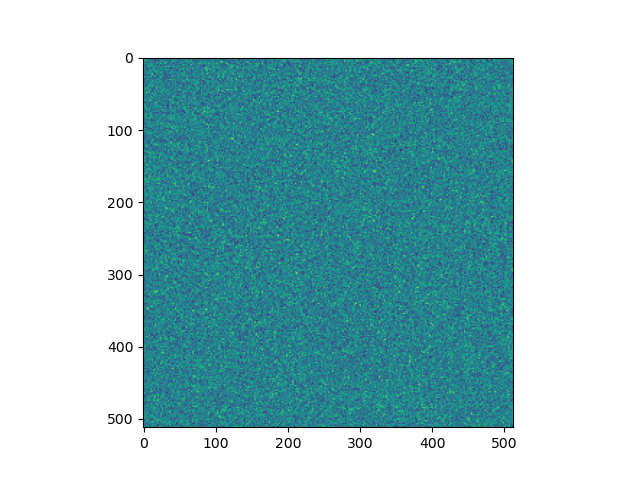

In [110]:
fig,ax = plt.subplots()

im = ax.imshow(np.zeros((512,512)),vmin=0.8,vmax=1.2)

# Fourier transform volume
volfft = np.fft.ifftshift(np.fft.fftn(np.fft.fftshift(volume)))

# We will need to "interpolate" the grid - estimate values in between the pixels and this
# function prepares for that
vol = RegularGridInterpolator(grid,volfft,method="linear",bounds_error=False,fill_value=0)
pixels = volume.shape[0]

def plot_propagator(rot,tilt,psi,dz,dose):
    """Function to plot the propagator"""
    wavefunction = np.exp(1j*project_volume(vol,rot,tilt,psi,returnfft=False))
    gaussian = Gaussian(1,[pixels,pixels],[size,size])
    propagator = ctf([pixels,pixels],[size,size],eV,df=dz*1e4,aberrations=cs(2.7))
    img = np.abs(np.fft.ifft2(np.fft.fft2(wavefunction)*propagator*np.fft.fft2(gaussian)))**2
    counts = dose*size*size
    img = img/np.sum(img)
    img = add_noise(img,counts )
    im.set_data(img)
    im.set_clim(vmin=img.min(),vmax=img.max())

    

interact(plot_propagator,rot =widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='rot:'),
         tilt= widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='tilt:'),
         psi = widgets.FloatSlider(value=0.0, min=0, max=360, step=1, description='psi:'),
         
         dz = widgets.FloatSlider(value=0.0,
                                               min=-5,
                                               max=5,
                                               step=0.01,description='$\\Delta$f ($\\mu$m):', readout_format='.2f')
         , dose = widgets.FloatLogSlider(value=40,
                                         base=10,
                                               min=1,
                                               max=5,
                                               step=0.01,description='e/Å$^2$:', readout_format='.2e'))
